In [20]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Import Data

In [7]:
segmented = '/kaggle/input/segmented-plants/segmented'
apple_black_rot = '/kaggle/input/segmented-plants/segmented/Apple___Black_rot'
apple_healthy = '/kaggle/input/segmented-plants/segmented/Apple___healthy'

In [8]:
train_transforms =  transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 45),
    # transforms.ScaleJitter(target_size=(224, 224), scale_range=(0.5, 2.0)),
    transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]),
])

In [9]:
val_transforms = transforms.Compose([
    transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
try:
    file = ImageFolder(root = segmented, transform = train_transforms)
    old_file = ImageFolder(root = segmented, transform = val_transforms )
    # file = ImageFolder(root = apple_black_rot)
    # apple_h = ImageFolder(root = apple_healthy)

except FileNotFoundError:
    print("File not found")


# Splitting the dataset

In [11]:
train_size = int(0.8 * len(file))
test_size = int(0.1 * len (file))
valid_size = len(file ) - test_size - train_size

train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(file, [train_size, test_size, valid_size])

BATCH_SIZE = 32

In [12]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)
valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

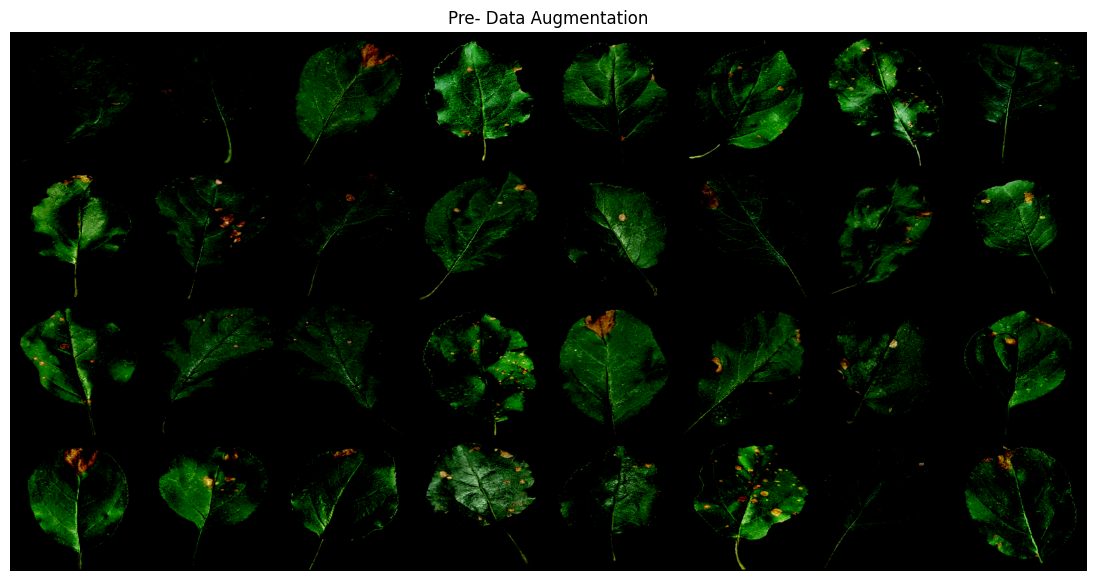

In [13]:
pre_aug =  DataLoader(
    dataset = old_file,
    batch_size = BATCH_SIZE,
    shuffle = False
)
image, label = next(iter(pre_aug))
grid = torchvision.utils.make_grid(image)
plt.figure(figsize=(15, 7))

# Transpose the grid from (C, H, W) to (H, W, C) for matplotlib
plt.imshow(grid.permute(1, 2, 0))

plt.title("Pre- Data Augmentation")
plt.axis('off')
plt.show()

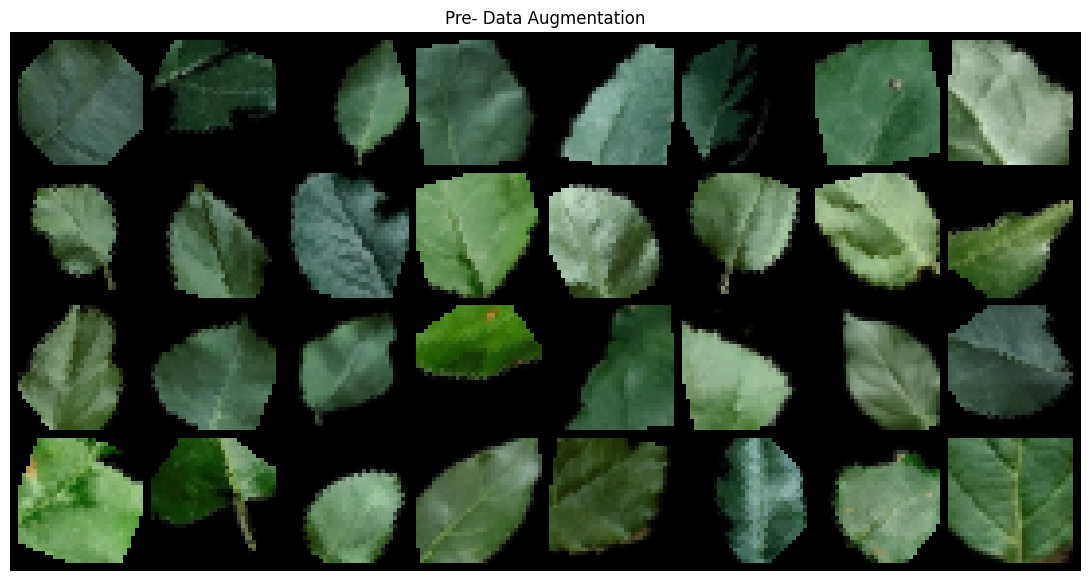

In [14]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

image, label = next(iter(train_loader))
grid = torchvision.utils.make_grid(image)
plt.figure(figsize=(15, 7))

# Transpose the grid from (C, H, W) to (H, W, C) for matplotlib
plt.imshow(grid.permute(1, 2, 0))

plt.title("Pre- Data Augmentation")
plt.axis('off')
plt.show()

# Augmenting Data 
Performing transformations on data helps:
* prevent overfitting
* expands the diversity of dataset
* robust + generalize 

In [16]:
weights = models.MobileNet_V3_Small_Weights.DEFAULT
model = models.mobilenet_v3_small(weights = weights )

In [28]:
# uses pre-existing weights in feature extractor layesr 
for param in model.parameters():
    param.requires_grad = False

# binary classification
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(128, 1) 
)

In [32]:
def train_model():
    # --- Device Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    
    criterion = nn.BCEWithLogitsLoss() 
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 3
    # aactual training 
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for (inputs, labels) in (train_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dummy_train_dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


In [31]:
train_model()

Using device: cpu


TypeError: conv2d() received an invalid combination of arguments - got (int, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!int!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!int!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
